In [20]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
eps=np.finfo(float).eps
from binarytree import tree,Node
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from operator import itemgetter
from pylab import *
import matplotlib
import matplotlib.pyplot as plt
import copy

In [21]:
# In[178]:
df=pd.read_csv("train.csv")
node_count=0

In [22]:
# In[179]:


X =df.drop(['left'],axis=1)
# X = pd.concat([X,pd.get_dummies(df['sales'], prefix='sales')],axis=1)
# X = pd.concat([X,pd.get_dummies(df['salary'], prefix='salary')],axis=1)
y=df['left']

In [23]:
# In[180]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

orignalX=copy.deepcopy(X_train)
orignalY=copy.deepcopy(y_train)
testX=copy.deepcopy(X_test)
testY=copy.deepcopy(y_test)
orignalX4=copy.deepcopy(X_train)
orignalY4=copy.deepcopy(y_train)
testX4=copy.deepcopy(X_test)
testY4=copy.deepcopy(y_test)
numeric=['last_evaluation','satisfaction_level','average_montly_hours','time_spend_company','number_project']


# In[181]:

In [24]:
def findParentEntropy(df):
    if df.empty==True:
        return
    classCol=df.keys()[-1]
    #yeh sirf header return karega
    resultValues=df[classCol].unique()
    #all ouput values in output column
    entropy=0
    for value in resultValues:
        fraction=df[classCol].value_counts()[value]/(len(df[classCol])+eps)
        entropy+=-fraction*np.log2(fraction+eps)
    return abs(entropy)
    
    


# In[182]:

In [25]:
def findRelativeEntropy(df,attribute):
    if df.empty==True:
        return
    classCol= df.keys()[-1] 
    #last col assumed as result 
    #getting target class 
    resultValues=df[classCol].unique() 
    attributeNames=df[attribute].unique()
    entropy2 = 0
    for attr in attributeNames:
        entropy = 0
        for value in resultValues:
            #temp&hot with yes
            num = len(df[attribute][df[attribute]==attr][df[classCol]==value])
            #total hot
            den = len(df[attribute][df[attribute]==attr])
            fraction = num/(den+eps)
            entropy += -fraction*np.log2(fraction+eps)
        #entropy attribute/total*(entropy attribute_values)
        fraction2 = den/len(df)  
        entropy2 += -fraction2*entropy 
    return abs(entropy2)


# In[183]:

In [26]:
def get_subtable(df, node,value):
    return df[df[node] == value].reset_index(drop=True)


# In[184]:

In [27]:
def get_subtableSmaller(df, node,value):
    if df.empty==True:
        return
    return df[df[node] < value].reset_index(drop=True)

In [28]:
# In[185]:


def get_subtableGreater(df, node,value):
    if df.empty==True:
        return
    return df[df[node] >= value].reset_index(drop=True)

In [29]:
# In[186]:

def bestAttribute(df):
    if df.empty==True:
        return
    infoGain={}
    max2=0
    attr=""
    entropy_1=findParentEntropy(df)
    for key in df.keys()[:-1]:
        
        if key not in numeric:
#             print("XXX-------",key)
            entropy_2=findRelativeEntropy(df,key)
            if ((entropy_1-entropy_2)) > max2:
                max2=entropy_1-entropy_2
                attr=key
    t=(max2,0)
    infoGain[attr]=t
    return infoGain
    

In [30]:
# In[187]:



df=pd.concat([orignalX4,orignalY4],axis=1)
def split(df):
    
    splitpoint={}
    entropy1=findParentEntropy(df)
    for col in numeric:
        # df.sort_values(col,inplace=True)
        prev=None;
        value=0;
        max1=0;
#         print(col)
        l=df[col].unique()
        for mid in l:
            # if prev is not None:
    #             if prev['left'] != row['left']:
            # mid=float(row[col])/2
            subtableLeft=get_subtableSmaller(df,col,mid)
            subtableRight=get_subtableGreater(df,col,mid)
            fraction=len(subtableLeft)/len(df)
            fraction1=len(subtableRight)/len(df)
#                 print(subtableLeft)
#                 a=input()
            firstSubtable=0
            secondSubtable=0
            if subtableLeft.empty:
                firstSubtable=0
            else:
                firstSubtable=fraction*findParentEntropy(subtableLeft)
#                 print(subtableRight)
            if subtableRight.empty:
                secondSubtable=0
            else:
                secondSubtable=fraction1*findParentEntropy(subtableRight)

            entropy2=firstSubtable+secondSubtable
            ig1=abs(entropy1)-abs(entropy2)

            if ig1>max1:
                max1=ig1
                value=mid
        # prev=row
        t=(max1,value)
        splitpoint[col]=t
    
    return splitpoint

In [31]:
class node:
    def __init__(self,value):
        self.value=value
        self.child=[]
        self.edges=[]
        self.positive=0
        self.negative=0


# In[190]:

In [32]:
def buildTree(df,depth):
    global node_count
    resultLabel= df.keys()[-1] 
    clValue,counts = np.unique(df[resultLabel],return_counts=True)
    
    
    if len(counts)<=1:
        root=node(clValue[0])
        node_count=node_count+1
        if clValue[0]==0:
            root.negative=counts[0]
        else:
            root.positive=counts[0]
   
    else:
        if depth==0:
            if counts[0]>counts[1]:
                root=node(clValue[0])
            else:
                root=node(clValue[1])
            node_count=node_count+1
            return root
        newsplit=split(df)
        calsplit=bestAttribute(df)
        newsplit.update(calsplit)
        maxig=0
        spoint=0
        attr=""
        for k,t1 in newsplit.items():
#             t1=i.value()
            if maxig<t1[0]:
                maxig=t1[0]
                spoint=t1[1]
                attr=k
        root=node(attr)
        node_count=node_count+1
        root.split=spoint
        root.positive=counts[1]
        root.negative=counts[0]
        
        if attr in numeric:
            subtable0 = get_subtableSmaller(df,attr,spoint)
    #         subtable0 =subtable0.drop([attribute_name],axis=1)
            subtable1 = get_subtableGreater(df,attr,spoint)
            root.child.append(buildTree(subtable0,depth-1))
            root.child.append(buildTree(subtable1,depth-1))
            
        else:
            for j in df[attr].unique():
                subtable0 = get_subtable(df,attr,j)
                root.edges.append(j)
                root.child.append(buildTree(subtable0,depth-1))

       
                   
    return root

In [33]:
# In[191]:


# print(df)
# root=buildTree(df)
# print(root.value)

def testing(row1,root):
    #     if root==None:
    #         return 
        #print(root.value)
        if len(root.child)==0:
            y1.append(root.value)
            return
    #     for i in row1.keys():
    #         if i==root.value:
        i=root.value
#         if i in row1:
        if i in numeric:
            if row1[i]<root.split:
                testing(row1,root.child[0])
            else:
                testing(row1,root.child[1])
        else:
            k=0
            #print("dd..",i)
            #print("sd...",len(root.edges))
            flag=0
            for j in root.edges:
                if row1[i]==j:
#                     print("inside")
                    flag=1
                    testing(row1,root.child[k])
                    break
                k=k+1
            if flag==0:
                if root.positive>root.negative:
                    y1.append(1)
                else:
                    y1.append(0)
                return
                        

In [34]:

def testingData(df):
    for index,row in df.iterrows():
        testing(row,root)
w=1
# while w>=4:
dep=[]
nod=[]
errorTest=[]
errorTestNode=[]
errorTrain=[]
errorTrainNode=[]
# w=20
while w<21:
    node_count=0
    root=buildTree(df,w)
#     print(root.value)


    copyX_test=copy.deepcopy(testX)
    y1=[] 
    testingData(X_test)  
#     print(len(y1))
    print("-------------------------Testing Data-------------------------------------------")
#     print(y_test)
#     print(type(y_test))
#     print(y1)
#     print(type(y1))
    print(confusion_matrix(y_test, y1))  
    print(accuracy_score(y_test,y1))
    dep.append(w+1)
    errorTest.append(1-accuracy_score(y_test,y1))
    nod.append(node_count)
#     errorTestNode[node_count]=1-accuracy_score(y_test,y1)
    print(classification_report(y_test, y1)) 
    print()
    y1.clear()
    copyorignalX=copy.deepcopy(orignalX)

    testingData(copyorignalX)
    # 
#     print(len(y1))
    print("-----------------------------Training Data-----------------------------------------")
    # orignalY=copy.deepcopy(y_train)
    print(confusion_matrix(orignalY, y1))  
    print(accuracy_score(orignalY,y1))
    errorTrain.append(1-accuracy_score(orignalY,y1))
#     errorTrainNode[node_count]=1-accuracy_score(orignalY,y1)
    print(classification_report(orignalY, y1)) 
    print()
    w=w+2
# print(errorTest)
# print(errorTestNode)
# print(errorTrain)
# print(errorTrainNode)

-------------------------Testing Data-------------------------------------------
[[1463  259]
 [ 144  382]]
0.8207295373665481
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1722
           1       0.60      0.73      0.65       526

   micro avg       0.82      0.82      0.82      2248
   macro avg       0.75      0.79      0.77      2248
weighted avg       0.84      0.82      0.83      2248


-----------------------------Training Data-----------------------------------------
[[5863  978]
 [ 633 1516]]
0.8208008898776418
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      6841
           1       0.61      0.71      0.65      2149

   micro avg       0.82      0.82      0.82      8990
   macro avg       0.76      0.78      0.77      8990
weighted avg       0.83      0.82      0.83      8990


-------------------------Testing Data-------------------------------------------
[[1633

-------------------------Testing Data-------------------------------------------
[[1686   36]
 [  12  514]]
0.9786476868327402
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1722
           1       0.93      0.98      0.96       526

   micro avg       0.98      0.98      0.98      2248
   macro avg       0.96      0.98      0.97      2248
weighted avg       0.98      0.98      0.98      2248


-----------------------------Training Data-----------------------------------------
[[6841    0]
 [   0 2149]]
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6841
           1       1.00      1.00      1.00      2149

   micro avg       1.00      1.00      1.00      8990
   macro avg       1.00      1.00      1.00      8990
weighted avg       1.00      1.00      1.00      8990




Text(0.5, 1.0, 'Depth vs Error')

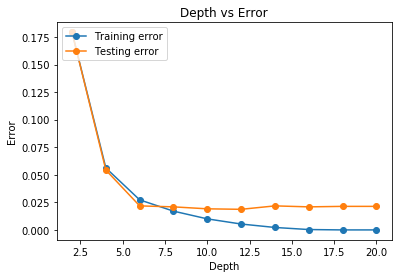

In [35]:
x_axis = [i for i in range(2,21,2)]
# figure()

fig, ax = plt.subplots()
# y_axis=
# plt.ylim(0.10,0.13)
ax.plot(x_axis, errorTrain, label="Training error",marker="o")
ax.plot(x_axis, errorTest, label="Testing error",marker="o")
# t = np.arange(-5.0, 5.0, 0.01)
ax.legend(loc=2) # upper left corner
ax.set_xlabel("Depth", fontsize=10)
ax.set_ylabel("Error", fontsize=10)
ax.set_title('Depth vs Error')

Text(0.5, 1.0, 'Node vs Error')

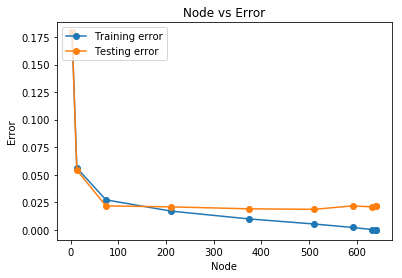

In [36]:
x_axis =nod
fig, ax = plt.subplots()
# y_axis=
# plt.ylim(0.10,0.13)
ax.plot(x_axis, errorTrain, label="Training error",marker="o")
ax.plot(x_axis, errorTest, label="Testing error",marker="o")
# t = np.arange(-5.0, 5.0, 0.01)
ax.legend(loc=2) # upper left corner
ax.set_xlabel("Node", fontsize=10)
ax.set_ylabel("Error", fontsize=10)
ax.set_title('Node vs Error')